In [1]:
# 📦 Imports
import os, cv2, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Input, Model

# 📂 Dataset path
DATASET_DIR = 'ProcessedFusionFull'
CLASSES = ['Drowsy', 'NonDrowsy']
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 15

# 🧠 Custom Data Generator
class FusionDataGenerator(Sequence):
    def __init__(self, base_dir, keys, label_dict, batch_size=8, img_size=128, shuffle=True):
        self.face_dir = {cls: os.path.join(base_dir, cls, 'face') for cls in CLASSES}
        self.dot_dir  = {cls: os.path.join(base_dir, cls, 'dotmap') for cls in CLASSES}
        self.lmk_dir  = {cls: os.path.join(base_dir, cls, 'landmark') for cls in CLASSES}
        self.keys = keys
        self.label_dict = label_dict
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        Xf, Xd, Xm, y = [], [], [], []

        for key in batch_keys:
            label = self.label_dict[key]
            cls = CLASSES[label]
            face = cv2.imread(os.path.join(self.face_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            dot  = cv2.imread(os.path.join(self.dot_dir[cls], key + '.png'), cv2.IMREAD_GRAYSCALE)
            lmk  = np.load(os.path.join(self.lmk_dir[cls], key + '.npy'))

            if face is None or dot is None or lmk.shape[0] != 478:
                continue

            face = cv2.resize(face, (self.img_size, self.img_size)) / 255.0
            dot  = cv2.resize(dot,  (self.img_size, self.img_size)) / 255.0

            Xf.append(face[..., np.newaxis])
            Xd.append(dot[..., np.newaxis])
            Xm.append(lmk.flatten())
            y.append(label)

        return {
            'face_in': np.array(Xf, dtype=np.float32),
            'dot_in':  np.array(Xd, dtype=np.float32),
            'lmk_in':  np.array(Xm, dtype=np.float32)
        }, np.array(y, dtype=np.float32)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.keys)

# 🏷️ Create label dictionary
label_dict = {}
for idx, cls in enumerate(CLASSES):
    face_path = os.path.join(DATASET_DIR, cls, 'face')
    for fname in os.listdir(face_path):
        if fname.endswith('.png'):
            key = os.path.splitext(fname)[0]
            label_dict[key] = idx

# 🔀 Split data
keys = list(label_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.1, stratify=[label_dict[k] for k in keys], random_state=42)

# 📤 Create generators
train_gen = FusionDataGenerator(DATASET_DIR, train_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen   = FusionDataGenerator(DATASET_DIR, val_keys, label_dict, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# 🧠 Model definition
landmark_dim = 478 * 2

face_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='face_in')
x1 = layers.Conv2D(32, 3, activation='relu')(face_in)
x1 = layers.MaxPooling2D()(x1)
x1 = layers.Conv2D(64, 3, activation='relu')(x1)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)

dot_in = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='dot_in')
x2 = layers.Conv2D(32, 3, activation='relu')(dot_in)
x2 = layers.MaxPooling2D()(x2)
x2 = layers.Conv2D(64, 3, activation='relu')(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation='relu')(x2)

lmk_in = Input(shape=(landmark_dim,), name='lmk_in')
x3 = layers.Dense(128, activation='relu')(lmk_in)
x3 = layers.Dense(64, activation='relu')(x3)

merged = layers.concatenate([x1, x2, x3])
z = layers.Dense(64, activation='relu')(merged)
z = layers.Dropout(0.4)(z)
out = layers.Dense(1, activation='sigmoid', name='out')(z)

model = Model(inputs=[face_in, dot_in, lmk_in], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 🚀 Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# 💾 Save
model.save("fatigue_fusion_model_generator_90.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ face_in             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_in (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        320 │ face_in[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 254, 254,  │        320 │ dot_in[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 127, 127,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lmk_in (InputLayer) │ (None, 956)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    122,496 │ lmk_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     20,544 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout[0][0]   

 Total params: 205,633 (803.25 KB)

 Trainable params: 205,633 (803.25 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\AkiraVI\Desktop\fyp coding\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 783s 540ms/step - accuracy: 0.6012 - loss: 0.6602 - val_accuracy: 0.7374 - val_loss: 0.4890
Epoch 2/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 735s 511ms/step - accuracy: 0.7616 - loss: 0.4847 - val_accuracy: 0.8310 - val_loss: 0.4161
Epoch 3/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 718s 499ms/step - accuracy: 0.8223 - loss: 0.3912 - val_accuracy: 0.8738 - val_loss: 0.2880
Epoch 4/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 714s 496ms/step - accuracy: 0.8689 - loss: 0.3263 - val_accuracy: 0.8978 - val_loss: 0.2797
Epoch 5/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 709s 493ms/step - accuracy: 0.8975 - loss: 0.2750 - val_accuracy: 0.9241 - val_loss: 0.2071
Epoch 6/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 709s 493ms/step - accuracy: 0.9206 - loss: 0.2277 - val_accuracy: 0.9587 - val_loss: 0.1442
Epoch 7/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 751s 522ms/step - accuracy: 0.9335 - loss: 0.1927 - val_accuracy: 0.9666 - val_loss: 0.1131
Epoch 8/15
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 773s 537ms/step - ac

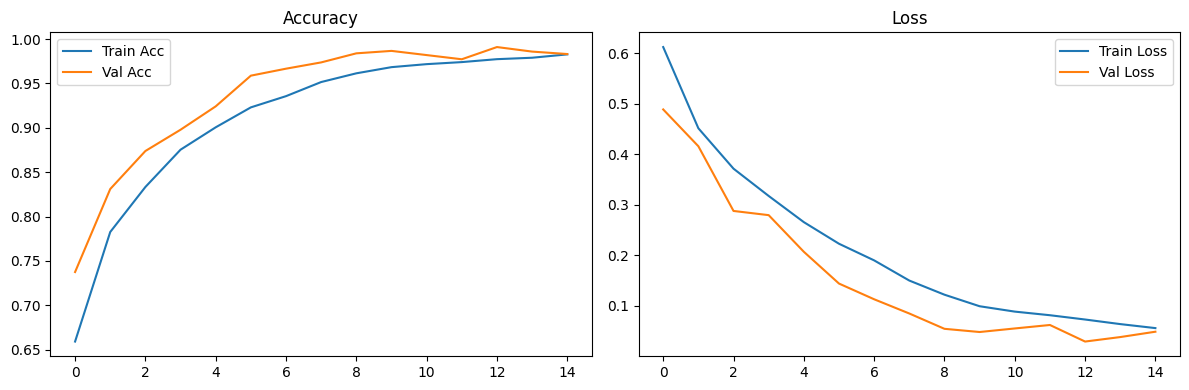

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
    